In [1]:
# -*- coding: utf-8 -*-
import recon
import plotting as plot
import numpy as np
import seaborn as sns
import pandas as pd
import utilities
import workflows as wf
import warnings
warnings.filterwarnings('ignore')


model = recon.Recon()
util = utilities.Utilities()
sns.set_context("talk")

### Metabolomics data

In [2]:
met_slc25a51ko = pd.read_csv('../data/metabolomics_slc25a51ko_vs_parental.csv', 
                             sep='\t', index_col=0)
met_uc = pd.read_csv('../data/metabolomics_uc_vs_healthy.csv', sep=',')

### Predicted change

In [3]:
res_slc25a51ko = pd.read_csv('../data/pr_slc25a51ko_wt.csv', sep='\t', index_col=0)
res_slc25a51ko_pvalue = pd.read_csv('../data/pr_slc25a51ko_wt_pvalue.csv', sep='\t', index_col=0)
res_uc = pd.read_csv('../data/pr_prot_uc_vs_healthy.csv', sep='\t', index_col=0)

### RNA-Seq data

In [ ]:
rna_slc25a51ko = pd.read_csv('../data/rnaseq_slc25a51ko_vs_parental.csv', sep='\t', index_col=0)
rna_slc25a51ko = util.map_gene(df=rna_slc25a51ko, g_mapping=model.genes, mapping_column='ensembl_gene')
rna_slc25a51ko_pvalue = pd.read_csv('../data/rnaseq_slc25a51ko_vs_parental_pvalue.csv', index_col=0)
rna_slc25a51ko_pvalue.index = rna_slc25a51ko_pvalue.index.astype('str')

# Parity plots with standard deviation

### Figure S1 (SLC25A51ko vs Parental)

In [ ]:
res_HEK = util.reshape(res_slc25a51ko, include=None)
# _res = res_HEK.groupby('metabolites').mean(numeric_only=True)
_res = res_HEK[res_HEK.compartment.isin(['mitochondrial', 'nuclear', 'cytoplasm'])].groupby(
    'metabolites').mean(numeric_only=True)
_res_m = res_HEK[res_HEK.compartment == 'mitochondrial'].groupby(
    'metabolites').mean(numeric_only=True)
_res_n = res_HEK[res_HEK.compartment == 'nuclear'].groupby(
    'metabolites').mean(numeric_only=True)
_res_c = res_HEK[res_HEK.compartment == 'cytoplasm'].groupby(
    'metabolites').mean(numeric_only=True)
df_mean = wf.prep_data(model=model, rna=rna_slc25a51ko, mets=met_slc25a51ko, res=_res)
df_m = wf.prep_data(model=model, rna=rna_slc25a51ko, mets=met_slc25a51ko, res=_res_m)
df_n = wf.prep_data(model=model, rna=rna_slc25a51ko, mets=met_slc25a51ko, res=_res_n)
df_c = wf.prep_data(model=model, rna=rna_slc25a51ko, mets=met_slc25a51ko, res=_res_c)

In [ ]:
# Figure S1a
_df = df[~df.index.isin(['D-Glucose', ])]
plot.parity_with_errorbars(df=_df, xcolumn='Predicted', ycolumn='Measured',
                        xerr_column='Predicted std_dev', yerr_column='Measured std_dev',
                        figsize=(8,7), xlim=(-0.5, 0.5), ylim=(-3.5, 3.5),
                        show_metabolite_names=True, show_percentage=True,
                        l_p=[(0.05, 0.95), (0.6, 0.95), (0.05, 0.35), (0.6, 0.35)],
                        l_n=[(0.15, 0.90), (0.6, 0.90), (0.05, 0.30), (0.6, 0.30)],
                        save=False, filename=None,
                        n_n=[1, 1, 2, 1])

In [ ]:
for i, df in enumerate([df_m, df_c, df_n]):
    _df = df[~df.index.isin(['D-Glucose', ])]
    plot.parity_with_errorbars(df=_df, xcolumn='Predicted', ycolumn='Measured',
                               xerr_column='Predicted std_dev', yerr_column='Measured std_dev',
                               figsize=(8, 7), xlim=(-0.5, 0.5), ylim=(-3.5, 3.5),
                               show_metabolite_names=True, show_percentage=True,
                               l_p=[(0.05, 0.95), (0.6, 0.95), (0.05, 0.35), (0.6, 0.35)],
                               l_n=[(0.15, 0.90), (0.6, 0.90), (0.05, 0.30), (0.6, 0.30)],
                               save=False, filename=None, n_n=[1, 1, 2, 1])

### Figure S2

In [ ]:
res_HEK = util.reshape(res_slc25a51ko_pvalue, include=None)
# _res = res_HEK.groupby('metabolites').mean(numeric_only=True)
_res = res_HEK[res_HEK.compartment.isin(['mitochondrial', 'nuclear', 'cytoplasm'])].groupby(
    'metabolites').mean(numeric_only=True)
_res_m = res_HEK[res_HEK.compartment == 'mitochondrial'].groupby(
    'metabolites').mean(numeric_only=True)
_res_n = res_HEK[res_HEK.compartment == 'nuclear'].groupby(
    'metabolites').mean(numeric_only=True)
_res_c = res_HEK[res_HEK.compartment == 'cytoplasm'].groupby(
    'metabolites').mean(numeric_only=True)
df_mean = wf.prep_data(model=model, rna=rna_slc25a51ko_pvalue,
                       mets=met_slc25a51ko, res=_res)
df_m = wf.prep_data(model=model, rna=rna_slc25a51ko_pvalue,
                    mets=met_slc25a51ko, res=_res_m)
df_n = wf.prep_data(model=model, rna=rna_slc25a51ko_pvalue,
                    mets=met_slc25a51ko, res=_res_n)
df_c = wf.prep_data(model=model, rna=rna_slc25a51ko_pvalue,
                    mets=met_slc25a51ko, res=_res_c)

In [ ]:
for i, df in enumerate([df_mean, df_m, df_c, df_n]):
    _df = df[~df.index.isin(['D-Glucose', ])]
    plot.parity_with_errorbars(df=_df, xcolumn='Predicted', ycolumn='Measured',
                               xerr_column='Predicted std_dev', yerr_column='Measured std_dev',
                               figsize=(8, 7), xlim=(-0.5, 0.5), ylim=(-3.5, 3.5),
                               show_metabolite_names=True, show_percentage=True,
                               l_p=[(0.05, 0.95), (0.6, 0.95),
                                    (0.05, 0.35), (0.6, 0.35)],
                               l_n=[(0.15, 0.90), (0.6, 0.90),
                                    (0.05, 0.30), (0.6, 0.30)],
                               save=False, filename=None, n_n=[1, 1, 2, 1])

### Figure S3

In [4]:
df = util.reshape(res_uc).groupby('metabolites').mean(numeric_only=True).reset_index()
df = met_uc.merge(df, right_on='metabolites', left_on='vmh', how='inner')
df = df.set_index('metabolites').drop('vmh', axis=1)
df.columns = ['p', 'padj', 'Measured', 'Predicted']
df['hue'] = 'C1'
df.loc[(df.p > 0.05), 'hue'] = 'grey'
df.loc[(df.Predicted < 1.01) & (df.Predicted > 0.99), 'hue'] = 'grey'
df.loc[(df.Measured < 1.2) & (df.Measured > 0.8), 'hue'] = 'grey'

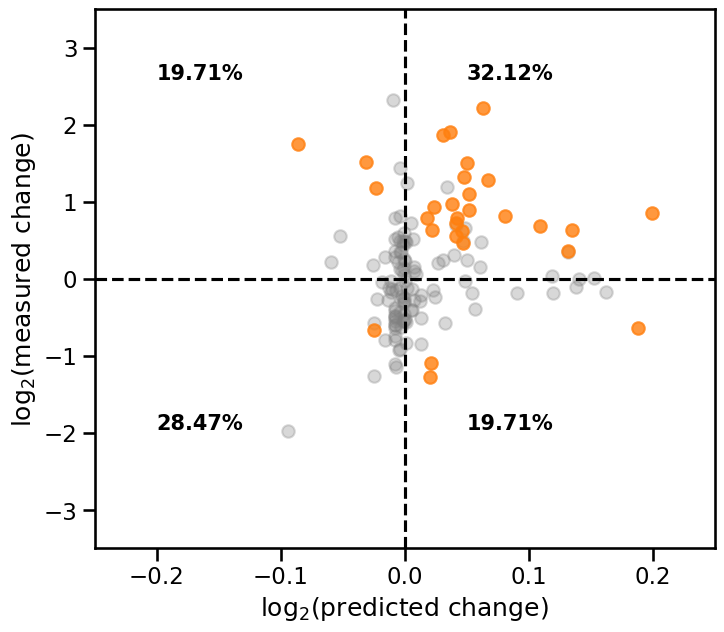

In [6]:
import matplotlib.pyplot as plt
xcolumn='Predicted'
ycolumn='Measured'
xlim=(-0.25, 0.25) 
ylim=(-3.5, 3.5)
xlabel='log$_2$(predicted change)' 
ylabel='log$_2$(measured change)'
l_p=[(0.1, 0.9), (0.6, 0.9), (0.1, 0.25), (0.6, 0.25)]
            
fig, ax = plt.subplots(figsize=(8,7))
ax.scatter(x=np.log2(df[df.hue=='grey'][xcolumn]), y=np.log2(df[df.hue=='grey'][ycolumn]), 
        c='grey', alpha=0.3)
ax.scatter(x=np.log2(df[df.hue!='grey'][xcolumn]), y=np.log2(df[df.hue!='grey'][ycolumn]), 
        c='C1', alpha=0.8)
ax.axhline(y=0.0, c='k', ls='--')
ax.axvline(x=0.0, c='k', ls='--')
plt.xlim(xlim)
plt.ylim(ylim)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
plot.add_percentage(df=df, ax=ax, colname2='Predicted', colname='Measured',
                    show_sc_percentages=False, fsize=15, 
                    l=l_p[0], l2=l_p[1], l3=l_p[2], l4=l_p[3]
                    )
fig.savefig('../../biomarker_predictions/manuscript/submission/images/Figure_S3.svg', dpi=300, bbox_inches='tight')